In [3]:
import nest_asyncio
nest_asyncio.apply()


from telethon import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest

api_id = 2431318
api_hash = '6f0a9ed2582bb334911c2915871fafb9'

client = TelegramClient('session_name', api_id, api_hash)

async def main():
    username = '@username'

    user = await client.get_entity(username)

    timestamps_history = []
    
    offset = 0
    has_messages = True
    while has_messages:
        history = await client(GetHistoryRequest(
            peer=user,
            limit=200,
            offset_date=None,
            offset_id=0,
            max_id=0,
            min_id=0,
            add_offset=offset,
            hash=0))
        
        has_messages = False
        for message in history.messages:
            has_messages = True
            timestamps_history.append((message.date, message.out, message.message))
            
        offset += len(history.messages)
        if offset % 1000 == 0:
            print(offset)
        
        

    
    def split_history_into_replicas(history):
        replicas = []

        
        print("messages size:", len(history))

        i = 0
        while i < len(history):
            replica = []
            while i < len(history) and history[i][1]:
                replica.append(history[i])
                i += 1
            if replica:
                replica.reverse()
                replicas.append(replica)

            replica = []
            while i < len(history) and not history[i][1]:
                replica.append(history[i])
                i += 1
            if replica:
                replica.reverse()
                replicas.append(replica)

        replicas.reverse()
        return replicas



    replicas = split_history_into_replicas(timestamps_history)
    
    her_diffs = []
    my_diffs = []

    for i in range(len(replicas) - 1):
        first_next = replicas[i + 1][0]
        last_current = replicas[i][-1]
        diff = first_next[0] - last_current[0]
        if last_current[2] and '?' in last_current[2]:
            print(last_current[2], '->', diff, '->', first_next[2])
            if last_current[1] and not first_next[1]:
                her_diffs.append(diff.seconds)
            else:
                my_diffs.append(diff.seconds)
        
    return (her_diffs, my_diffs)

async with client:
    diffs = client.loop.run_until_complete(main())

1000
2000
messages size: 2463


In [5]:
def build_distribution(data, step, left_th, right_th):
    new_data = []
    for ts in data:
        if left_th <= ts <= right_th:
            new_data.append(ts)
            
    data = new_data
    
    bins = max(data) // step + 1
    dist = [0] * bins 
    for x in data:
        dist[x // step] += 1
        
    log_dist = []
    i = 0
    bin_size = 1
    while i < len(dist):
        next_i = i + bin_size
        res = 0
        while i < next_i and i < len(dist):
            res += dist[i]
            i += 1
        log_dist.append(res)
        bin_size *= 1.1
        
    for i in range(len(log_dist)):
        log_dist[i] /= len(data)
     
    return log_dist

step = 1
left_threshold = 0
right_threshold = 200000

from statistics import median, mean

def filter_th(dt, left_th, right_th):
    res = []
    for x in dt:
        if left_th <= x <= right_th:
            res.append(x)
    return res

right_slice = 5000

her_dists = build_distribution(diffs[0], step, left_threshold, right_threshold)[:right_slice]
my_dists = build_distribution(diffs[1], step, left_threshold, right_threshold)[:right_slice]
print("username: her median:", median(filter_th(diffs[0], left_threshold, right_threshold)),
            "my median:", median(filter_th(diffs[1], left_threshold, right_threshold)))
print("username: her mean:", mean(filter_th(diffs[0], left_threshold, right_threshold)),
            "my mean:", mean(filter_th(diffs[1], left_threshold, right_threshold)))


username: her median: 159.0 my median: 35.5
username: her mean: 6424.25 my mean: 1721.7181818181818


In [6]:
def get_label_by_sec(sec):
    ss = sec % 60
    mm = (sec // 60) % 60
    hh = sec // 60 // 60
    
    res = ""
    if hh > 0:
        return str(hh) + "h"
    if mm > 0:
        if res:
            res += ' '
        return str(mm) + "m"
        
    if ss > 0:
        if res:
            res += ' '
        return str(ss) + "s"
        
        
        
x = []
labels = []
k = 1.1
bin_size = 1
curr = 0
last_label = -10
for i in range(100):
    if last_label + 5 < i:
        x.append(i)
        labels.append(get_label_by_sec(int(curr)))
        last_label = i
    curr += bin_size
    bin_size *= k

print(x, labels)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96] [None, '7s', '21s', '45s', '1m', '2m', '4m', '8m', '16m', '28m', '50m', '1h', '2h', '4h', '8h', '14h', '26h']


<Figure size 1280x480 with 0 Axes>

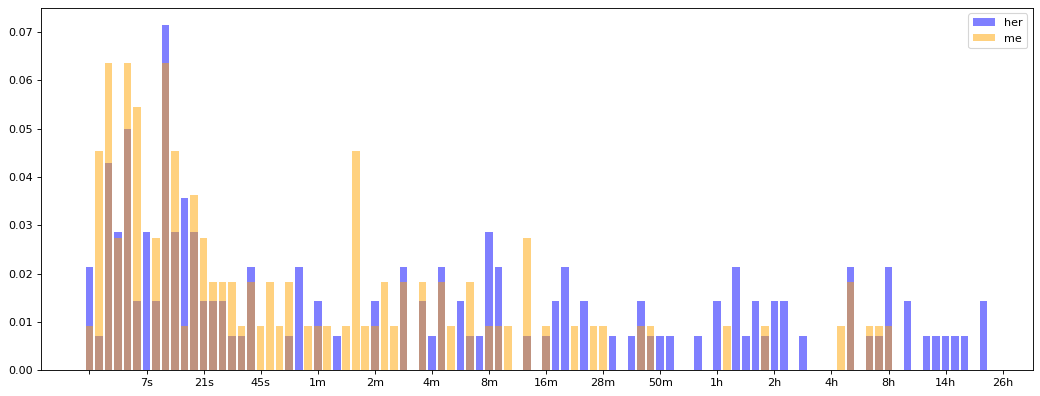

In [11]:
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')



figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar([i for i in range(len(her_dists))], her_dists, color='blue', alpha=0.5)
plt.bar([i for i in range(len(my_dists))], my_dists, color='orange', alpha=0.5)
plt.xticks(x, labels, rotation='horizontal')
plt.legend(['her', 'me'])
plt.show()